# CIFAR 10

21 Jan 2018

22 Jan 2018

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

You can get thed ata via:
```
wget http://pjreddie.com/media/files/cifar.tgz
```

In [2]:
from fastai.conv_learner import *
PATH = "data/cifar10/"
os.makedirs(PATH, exist_ok=True)

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [4]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [5]:
bs=256

## Look at dem der data

In [6]:
data = get_data(32, 4)

In [7]:
x,y = next(iter(data.trn_dl))

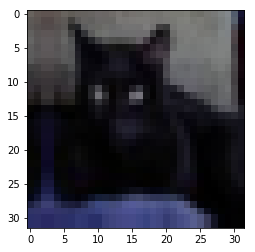

In [8]:
plt.imshow(data.trn_ds.denorm(x)[0]);

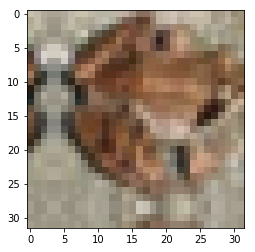

In [9]:
plt.imshow(data.trn_ds.denorm(x)[3]);

## Fully Connected Model

In [10]:
data = get_data(32,bs)

In [11]:
lr=1e-2

From [this notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by K.Turgutlu.

In [12]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for λ in self.layers:
            λ_x = λ(x)
            x = F.relu(λ_x)
        return F.log_softmax(λ_x, dim=-1)

In [13]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40, 10]), data)

In [14]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40)
     (1): Linear(in_features=40, out_features=10)
   )
 ), [122880, 40, 400, 10])

In [35]:
[o for o in learn.model.parameters()]

[Parameter containing:
 -6.4338e-03  1.5326e-02 -1.5924e-02  ...   1.1547e-02 -9.0885e-03 -1.4649e-02
  7.7094e-03 -1.0558e-02 -8.9114e-03  ...   2.8448e-03  1.5704e-02  3.5775e-03
 -9.6430e-03  6.4865e-03 -1.5673e-02  ...  -4.0456e-03  1.0989e-03  1.1022e-02
                 ...                   ⋱                   ...                
  2.1720e-03 -7.6407e-03 -4.6671e-03  ...  -1.9418e-03 -3.6204e-03 -1.0774e-02
  7.8809e-03 -1.6233e-02  1.1299e-02  ...   1.7158e-03  1.6630e-02 -3.0536e-03
  1.6010e-02  1.0412e-02  8.9523e-03  ...  -1.0815e-02  9.0351e-03  5.6351e-04
 [torch.cuda.FloatTensor of size 40x3072 (GPU 0)], Parameter containing:
 1.00000e-02 *
   1.1818
   0.4050
  -0.6216
   0.3488
  -0.8495
  -1.0857
  -0.7687
   1.5006
   1.2637
   0.8516
  -1.4815
   1.3691
  -1.2252
  -1.6819
   0.5080
  -0.5053
  -1.0665
  -1.2321
   0.4002
   0.8097
  -0.9507
   1.3731
   1.7077
   1.0292
   0.6423
  -1.4595
  -0.5423
   1.3911
   0.3411
   1.4390
  -0.4499
  -1.2129
   1.6920
   1.4

In [15]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 76%|███████▌  | 149/196 [00:09<00:03, 15.51it/s, loss=21.6]


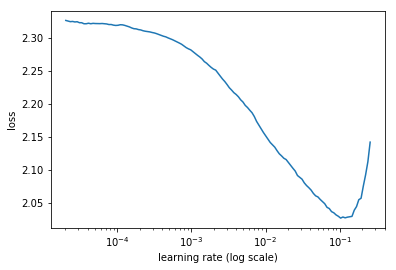

In [16]:
learn.lr_find()
learn.sched.plot()

In [17]:
%time learn.fit(lr,2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch:   0, train_loss: 1.746623, val_loss: 1.631227, accuracy: 0.423633
epoch:   1, train_loss: 1.661312, val_loss: 1.558321, accuracy: 0.448047

CPU times: user 1min 7s, sys: 20.7 s, total: 1min 27s
Wall time: 45 s


In [18]:
%time learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch:   0, train_loss: 1.609712, val_loss: 1.507847, accuracy: 0.473438
epoch:   1, train_loss: 1.588556, val_loss: 1.493332, accuracy: 0.473633

CPU times: user 1min 10s, sys: 21.1 s, total: 1min 31s
Wall time: 46.9 s


The goal is to basically replicated the basic architecture of a ResNet. The simple model above gets an accuracy of around 47%, with 120,000 parameters. Not great. We're deffinitely not using our parameters very well -- they're treating each pixel with a different weight.

Instead we'll find groups of 3x3 pixels with particular patterns, using a ConvNet.

## 3. CNN

The first step is to replace our FullNet model with a ConvNet model.

In [22]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
    
    def forward(self, x):
        for λ in self.layers: x = F.relu(λ(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

`nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)`: the first two pars are exactly the same as `nn.Linear`: num_features_in, num_features_out

In [23]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

`learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)`: 3 channels coming in; 1st layer comes out with 20, 2nd with 40, 3rd: 80.

In [24]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

To turn the output of the ConvNet into a prediction of one of ten classes is use Adaptive Max Pooling. Standard now for SotA algorithms. A Max Pool is done on the very last layer. Instead of a 2x2 or 3x3 or X-by-X, in Adaptive Max Pooling, we don't tell the algorithm how big an area to pool, instead we tell it how big a resolution to create.

So doing a 14x14 adaptive max pool on a 28x28 input image (like CIFAR-10 in this case) is the same as a 2x2 Max Pool. A 2x2 AMP would be the same as a 14x14 MP on a 28x28 image.

What we pretty much always do in modern CNNs is make the penultimate layer a 1x1 Adaptive Max Pool. ie: find the single largest cell and use that as our new activation.

That gives us a 1x1xNum_Features Tensor that we can send into our FullNet.

Then we do:
`x = x.view(x.size(0), -1)` which returns a matrix of Mini_Batch x Num_Features.

We can feed that into a linear layer, with however many classes we need.

In [25]:
learn.lr_find(end_lr=100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 71%|███████   | 139/196 [00:30<00:12,  4.63it/s, loss=12.5]

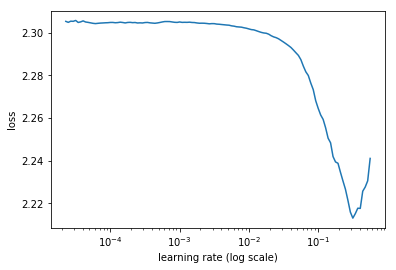

In [26]:
learn.sched.plot()

In [27]:
%time learn.fit(1e-1, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

 44%|████▍     | 86/196 [00:09<00:12,  9.16it/s, loss=1.93]

Exception in thread Thread-12:
Traceback (most recent call last):
  File "/home/wnixalo/miniconda3/envs/sdnfastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/wnixalo/miniconda3/envs/sdnfastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/wnixalo/miniconda3/envs/sdnfastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch:   0, train_loss: 1.710318, val_loss: 1.583743, accuracy: 0.418945
epoch:   1, train_loss: 1.528429, val_loss: 1.508869, accuracy: 0.452637

CPU times: user 1min 10s, sys: 21.5 s, total: 1min 32s
Wall time: 47.5 s


In [28]:
%time learn.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch:   0, train_loss: 1.458819, val_loss: 1.370406, accuracy: 0.498730
epoch:   1, train_loss: 1.343323, val_loss: 1.288380, accuracy: 0.533984
epoch:   2, train_loss: 1.296054, val_loss: 1.237626, accuracy: 0.552148
epoch:   3, train_loss: 1.274037, val_loss: 1.206334, accuracy: 0.567383

CPU times: user 2min 20s, sys: 42.5 s, total: 3min 3s
Wall time: 1min 34s


We have around 30,000 parameters in the ConvNet, about a quarter that in the simple FullNet, and our accuracy is around 57%, up from 47%.

## 4. Refactored

We're going to refactor the ConvNet slightly so that we put less stuff in the forward pass. For instance, calling `relu` each loop isn't ideal. So we'll create a new class called ConvLayer which contains a convolution with a kernel size of 3 and a stride of two, and with padding. Padding becomes especially important when you're down to small layer sizes in later convolutions where throwing away a potential convolution around the edge will lose a significant amount of information.

The relu will be inside the ConvLayer class, making it easier to edit and prevent bugs.

In [30]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [32]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1]) 
                                     for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for λ in self.layers: x = λ(x)
        x = F.adaptive_max_pool2d(x, 1) # F is nn.Functional
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

What's awesome about PyTorch is that a Layer definition and a Neural Network definition are literally identical. They both have a Constructor, and a Forward. Any time you have a layer, you can use it as a neural net, and vice versa.

Also, since AMP has no state (no weights), we don't need to have it as an attribute as in the ConvNet class up above, we can instead call it as a function in the Forward method of ConvNet2.

In [35]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [36]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [37]:
%time learn.fit(1e-1, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch:   0, train_loss: 1.705217, val_loss: 1.590567, accuracy: 0.401367
epoch:   1, train_loss: 1.522207, val_loss: 1.381575, accuracy: 0.505371

CPU times: user 1min 10s, sys: 21.8 s, total: 1min 32s
Wall time: 47.7 s


In [ ]:
%time learn.fit(1e-1, 2, cycle_len=1)

## 5. BatchNorm

An issue up above, is that we're having trouble training the ConvNet as we add more layers. If we use larger learningRates, we get NaNs (Infinities), and smaller lrs take forever and doesn't have a chance to explore properly. So it isn't resilient.

To make the model more resilient, we'll use Batched Normalization. BatchNorm is a couple years old now (2018), and makes it much easier to train deep networks.

The network we're going to create will have more layers: 5 Conv layers and 1 Full layer. Back in the day that'd be considered a pretty deep network and would be hard to train. It's very simple now thanks to Batch Norm.

Batch Norm can be used by calling nn.BatchNorm.., we'll write it from scratch to learn about it.

In [38]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf, 1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training: # true for training set. false for val set.
            self.means = x_chan.mean(1)[:, None, None]
            self.stds  = x_chan.std(1)[:, None, None]
        return (x-self.means) / self.stds * self.m + self.a

this is normalizing our input automatically per channel, and for later layers: per filter. but this isn't enough because SGD is a bloody-minded soldier. It will keep changing the activations to what it thinks they should be each minibatch, BatchNorm be damned.

In fact, that last line on it's own: `(x-self.means) / self.std` literally does nothing, because SGD just undoes it the next minibatch.

So what we do, is create a new multiplier for each channel and a new added value, `self.m` & `self.a` -- the adder is just 3 zeros, `self.a = nn.Parameter(torch.zeros(nf,1,1))`, and the multiplier is just 3 ones: `self.m = nn.Parameter(torch.ones(nf, 1,1))`

-- `nf` is number of filters, 3 in our case --

We set those to be parameters. By specifying them as `nn.Paramter(..)` we tell PyTorch it's allowed to learn these as weights. So initially it subtracts the Means, divides the Standard Deviations, multiplies by Ones, and adds Zeroes. Nothing much happens.

Now, though, when SGD wants scale the layer up, it doesn't have to scale up every value in the matrix: it can just scale up the single trio of numbers `self.m`, the multiplier. Likewise if it wants to shift the matrix activations up or down a bit, it doesn't have to shift the entire weight matrix: it can just shift the trio of numbers `self.a`, the adder.

We're normalizing the data, then saying you can shift and scale it using far fewer parameters than would've been necessary if I was asking you to shift and scale the entire set of Conv filters.

In practice what this does is allow us to increase our learning rates and increase the resilience of training and allows us to add more layers.

In this case, adding BNLayer instead of the original ConvLayer to the model allows us to add more layers (the `80` and `160` below in the learner), and still train it effectively.

Another great thing BatchNorm does is regularize the network. IoW: you can decrease or remove dropout and weightdecay. The reason why is that each minibatch is going to have a different mean and standard deviation; so they keep changing --> this keeps changing the meaning of the filters --> this has a regularizing effect because it's noise. When you add noise of any kind, it regularizes your model.

In [42]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
                                    for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for λ in self.layers: x = λ(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

NOTE: this is a simplified version of BatchNorm! In real BatchNorm, instead of just taking the mean & stddev of the minibatch, you take an exponentially weighted moving average stddev & mean.

A change in ConvBnNet -- in line with modern approaches -- is the addition of a single Conv layer in the beginning with a kernel size of 5 and a stride of 1. The reason is to make sure the first layer has a richer input: sampling from a larger area. This first layer outputs 10 5x5 filters. Padding size is kernel size - 1 / 2 = 2.

In [43]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [44]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [45]:
  %time learn.fit(3e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch:   0, train_loss: 1.501209, val_loss: 1.378246, accuracy: 0.500391
epoch:   1, train_loss: 1.271132, val_loss: 1.169939, accuracy: 0.582324

CPU times: user 1min 8s, sys: 22 s, total: 1min 30s
Wall time: 49.5 s


In [46]:
%time learn.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch:   0, train_loss: 1.148769, val_loss: 1.061885, accuracy: 0.624512
epoch:   1, train_loss: 1.033622, val_loss: 0.957323, accuracy: 0.658398
epoch:   2, train_loss: 0.967115, val_loss: 0.873954, accuracy: 0.691406
epoch:   3, train_loss: 0.916107, val_loss: 0.837333, accuracy: 0.704688

CPU times: user 2min 17s, sys: 44.1 s, total: 3min 1s
Wall time: 1min 38s


In [48]:
t1 = [chr(ord('a')+i) for i in range(10)]
t2 = [chr(ord('ა')+i) for i in range(10)]

for a,b in zip(t1, t2):
    print(a)
    print(b)

a
ა
b
ბ
c
გ
d
დ
e
ე
f
ვ
g
ზ
h
თ
i
ი
j
კ


## 6 Deep BatchNorm

Take a look at the accuracy rise (note val-loss < trn-loss, signaling no overfitting yet) from 47% -> 57% before, up to 70%. Woo! Okay, personal note: THIS IS SO MUCH EASIER THAN I IMAGINED.

So, given that this is looking so good, and obvious thing to try increasing the depth of the model. We can't just add more of our stride-2 layers, because they halve the size each time (we're down to 2x2 by the end), so instead we create a stride-1 layer (no size-change) for each stride-2 layer created. Then zip the stride2 & stride1 layers together ( s-2 first ), which gives us alternating stride 2, 1 layers.

This however, doesn't help because the model is now too deep for even batch norm to handle on it's own (12 layers (start-Conv, 10 S2-S1 Convs, 1 Linear))

In [54]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i+1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for λ, λ2 in zip(self.layers, self.layers2):
            x = λ(x)
            x = λ2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [55]:
learn = ConvLearner.from_model_data(ConvBnNet2([10,20,40,80,160],10), data)

In [56]:
%time learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch:   0, train_loss: 1.529784, val_loss: 1.414645, accuracy: 0.495117
epoch:   1, train_loss: 1.324366, val_loss: 1.244051, accuracy: 0.554590

CPU times: user 1min 21s, sys: 27.9 s, total: 1min 49s
Wall time: 1min 6s


In [57]:
%time learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch:   0, train_loss: 1.141864, val_loss: 1.073342, accuracy: 0.612402
epoch:   1, train_loss: 1.083352, val_loss: 1.006783, accuracy: 0.638281

CPU times: user 1min 20s, sys: 28.1 s, total: 1min 48s
Wall time: 1min 6s


Notice making the model deeper hasn't helped. It's possible to train a standard ConvNet 12 layers deep, but it's hard to do properly. Instead we're going to replace the ConvNet with a ResNet.

## 7. ResNet

The ResnetLayer class is going to inherit from BnLayer and replace our forward with `return x + super().forward(x)`. And that's it. Everything else is going to be identical -- except that we're now going to make the network 4x deeper.

In [58]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [59]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
    
    def forward(self, x):
        x = self.conv1(x)
        for λ,λ2,λ3 in zip(self.layers, self.layers2, self.layers3):
            x = λ3(λ2(λ(x))) # function of a function of a function
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

And now this model is going to train beautifully just because of that one line: `def forward(self, x): return x + super().forward(x)`. Why is that?

This is called a ResNet block. It says its prediction $$y = x + f(x)$$ in this case the function is a convolution. Which is also saying: $$f(x) = y - x$$, where `f(x)` is the current layer's prediction, `y` is the prediction from the previous layer. What it's doing is trying to fit a function `f` to the difference between `y` and `x`. That difference is the *residual*. 

If `y` is what I'm trying to calculate, and `x` is the thing I've most recently calculated (input to current layer), then the difference between the two is essentially the error ito what I've calc'd so far. So this is saying  *attempt to find a set of convolutional weights that attempts to fill in the amount I was off by.*

Lecture at ~ [1:55:00](https://youtu.be/H3g26EVADgY?t=6900)

In [60]:
learn = ConvLearner.from_model_data(Resnet([10,20,40,80,160], 10), data)

In [61]:
wd=1e-5

In [62]:
%time learn.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch:   0, train_loss: 1.575531, val_loss: 1.490273, accuracy: 0.458008
epoch:   1, train_loss: 1.367692, val_loss: 1.304558, accuracy: 0.528223

CPU times: user 1min 31s, sys: 43.5 s, total: 2min 15s
Wall time: 1min 32s


In [63]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 1.194511, val_loss: 1.131561, accuracy: 0.591602
epoch:   1, train_loss: 1.141884, val_loss: 1.047088, accuracy: 0.624707
epoch:   2, train_loss: 1.011862, val_loss: 0.971565, accuracy: 0.650781
epoch:   3, train_loss: 1.055183, val_loss: 0.972103, accuracy: 0.651074
epoch:   4, train_loss: 0.944926, val_loss: 0.892520, accuracy: 0.684473
epoch:   5, train_loss: 0.836938, val_loss: 0.815006, accuracy: 0.711035
epoch:   6, train_loss: 0.802072, val_loss: 0.833698, accuracy: 0.703320

CPU times: user 5min 19s, sys: 2min 33s, total: 7min 53s
Wall time: 5min 24s


In [64]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=32), HTML(value='')))

epoch:   0, train_loss: 0.890402, val_loss: 0.886829, accuracy: 0.684668
epoch:   1, train_loss: 0.805048, val_loss: 0.781158, accuracy: 0.722070
epoch:   2, train_loss: 0.731827, val_loss: 0.760942, accuracy: 0.729395
epoch:   3, train_loss: 0.687590, val_loss: 0.720829, accuracy: 0.743945
epoch:   4, train_loss: 0.789133, val_loss: 0.785697, accuracy: 0.725977
epoch:   5, train_loss: 0.703599, val_loss: 0.733685, accuracy: 0.746582
epoch:   6, train_loss: 0.629897, val_loss: 0.696895, accuracy: 0.757129
epoch:   7, train_loss: 0.595758, val_loss: 0.661749, accuracy: 0.765527
epoch:   8, train_loss: 0.691196, val_loss: 0.700148, accuracy: 0.754590
epoch:   9, train_loss: 0.629629, val_loss: 0.669934, accuracy: 0.764941
epoch:  10, train_loss: 0.561016, val_loss: 0.654044, accuracy: 0.774219
epoch:  11, train_loss: 0.516393, val_loss: 0.611107, accuracy: 0.786035
epoch:  12, train_loss: 0.642323, val_loss: 0.670267, accuracy: 0.767285
epoch:  13, train_loss: 0.576197, val_loss: 0.65047

The idea is, if we have some inputs coming in and a function trying to predict how much the error is, then add on another prediction of error at that new stage, and on and on, then each time we're zooming in closer and closer to the correct answer -- ie: we've gotten to a certain point but there's still an error, a residual, so let's create a model that predicts that residual and add that onto our previous model, and another model that predicts *that* residual, and adds that on, and etc. If you keep doing that over and over, you should get closer and closer to our answer.

This is based on the theory of Boosting. By specifying `return x + super().forward(x)` as the thing we're trying to calculate, then we're kind of getting boosting for free.

Note that here, only one convolution is done in the ResNet block. Actual standard ResNet blocks use two convolutions before adding back onto the input.

Note also that the first layer in every block is a standard Conv layer w/ a stride of two, not a Res layer. This is a *bottleneck* layer. From time to time we change the geometry in a ResNet model. Actual ResNets don't use a standard Conv layer for bottlenecks; but that'll be covered in Part 2 of this course.

Still, this simplified ResNet gets up to 82% accuracy (incl. overfitting).

## 8. ResNet2

We can make the Resnet even bigger

In [68]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p) # dropout added
    
    def forward(self, x):
        x = self.conv1(x)
        for λ,λ2,λ3 in zip(self.layers, self.layers2, self.layers3):
            x = λ3(λ2(λ(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

Other than the minor simplification of ResNet, this is a reasonable approximation of a good starting point for a modern architecture.

In [69]:
# all sizes increased; 0.2 dropout
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [70]:
wd=1e-6

In [71]:
%time learn.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch:   0, train_loss: 1.767987, val_loss: 1.548520, accuracy: 0.448730
epoch:   1, train_loss: 1.601389, val_loss: 1.571254, accuracy: 0.489551

CPU times: user 2min, sys: 1min 20s, total: 3min 20s
Wall time: 2min 37s


In [72]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 1.320774, val_loss: 1.617262, accuracy: 0.561230
epoch:   1, train_loss: 1.295079, val_loss: 1.154138, accuracy: 0.594434
epoch:   2, train_loss: 1.108653, val_loss: 1.077898, accuracy: 0.623437
epoch:   3, train_loss: 1.149356, val_loss: 1.050946, accuracy: 0.626660
epoch:   4, train_loss: 1.043593, val_loss: 0.964791, accuracy: 0.677051
epoch:   5, train_loss: 0.910195, val_loss: 0.918646, accuracy: 0.690137
epoch:   6, train_loss: 0.862857, val_loss: 0.860469, accuracy: 0.702344

CPU times: user 6min 59s, sys: 4min 40s, total: 11min 40s
Wall time: 9min 12s


In [73]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=32), HTML(value='')))

epoch:   0, train_loss: 0.986333, val_loss: 0.885332, accuracy: 0.685840
epoch:   1, train_loss: 0.867391, val_loss: 0.863608, accuracy: 0.708398
epoch:   2, train_loss: 0.772305, val_loss: 0.746609, accuracy: 0.740918
epoch:   3, train_loss: 0.732321, val_loss: 0.737068, accuracy: 0.736523
epoch:   4, train_loss: 0.834940, val_loss: 0.819916, accuracy: 0.715332
epoch:   5, train_loss: 0.754747, val_loss: 0.710436, accuracy: 0.753223
epoch:   6, train_loss: 0.668873, val_loss: 0.677486, accuracy: 0.764258
epoch:   7, train_loss: 0.625177, val_loss: 0.674994, accuracy: 0.765527
epoch:   8, train_loss: 0.752331, val_loss: 0.747464, accuracy: 0.748340
epoch:   9, train_loss: 0.671920, val_loss: 0.666121, accuracy: 0.767383
epoch:  10, train_loss: 0.593670, val_loss: 0.651529, accuracy: 0.778125
epoch:  11, train_loss: 0.562150, val_loss: 0.611865, accuracy: 0.789258
epoch:  12, train_loss: 0.661946, val_loss: 0.663122, accuracy: 0.768750
epoch:  13, train_loss: 0.606065, val_loss: 0.65389

In [74]:
learn.save('tmp')

In [75]:
log_preds,y = learn.TTA()

In [76]:
preds = np.mean(np.exp(log_preds), 0)

In [77]:
metrics.log_loss(y,preds), accuracy(preds,y)

(0.4624261324987395, 0.843)

This accuracy was p.much SotA in 2012 for CIFAR-10. Today it's up to around 97%, but those implementations are all based on these techniques. It's mostly better approaches to data augmentation, regularization, resnset tweaks, etc.

The ResNet can be applied to a lot of non-image data, but has been ignored as of Dec 2017. The Transform architecture in NLP is essentially a very simplified Resnet analog and first of its kind.

The idea of skip connections -- common in computer vision, though nothing unique to it.